In [36]:
#! -*-coding:utf-8 -*-
import sys
sys.path.append('/content/OptimalDiffusion')
sys.path.append('/content/OptimalDiffusion/Toy-examples')

import os
import torch
import time
import numpy as np

from OptimalDiffusion.Toy_examples.lib.sde import SDE
from OptimalDiffusion.Toy_examples.lib.utils import visualize_diffusion_process_2d, visualize_line
from OptimalDiffusion.Toy_examples.lib.utils import weight_init
from OptimalDiffusion.Toy_examples.lib.basic_manifolds import SwissRoll, SCurve, Circles, Moons
from OptimalDiffusion.Toy_examples.lib.evaluate import evaluate_2d

torch.set_default_dtype(torch.float64)


In [1]:
import sys
import os
import torch
import time
import numpy as np

from lib.sde import SDE
from lib.utils import visualize_diffusion_process_2d, visualize_line
from lib.utils import weight_init
from lib.basic_manifolds import SwissRoll, SCurve, Circles, Moons
from lib.evaluate import evaluate_2d

torch.set_default_dtype(torch.float64)


## Visualize forward process

In [8]:
def visualize_forward_process(true_data, model, sample_size, T, N, data_dim, savename=None):
    t_unit = T / N
    t_schedule = np.arange(N + 1) * t_unit

    # forward process
    x_0 = true_data.sample(sample_size)
    x_0 = torch.from_numpy(x_0).view(-1, data_dim)

    x_t = list()

    for t in t_schedule:

        x_t.append(model.forward_sde(x_0, t, to_numpy=True))

    x_t = np.stack(x_t, axis=0)

    visualize_diffusion_process_2d(xs=x_t, titles=[f"t={t:.2f}" for t in t_schedule], savename=savename)


## Train the score matching model

In [9]:
# If model exists, load it
def train(model, ckpt_dir, true_data, batch_size, steps):
    if os.path.exists(os.path.join(ckpt_dir, "sde.pth")):
        model.load_state_dict(torch.load(os.path.join(ckpt_dir, "sde.pth")))
        print(f"model loaded from {os.path.join(ckpt_dir, 'sde.pth')}")
    
    # otherwise, train it
    else:
        print(f"begin to train")
        model.estimate_score(data_iter=true_data.data_iter(batch_size=batch_size, maxiter=steps), steps=steps, lr=1e-2)
        print(f"finish training")
    
        torch.save(model.state_dict(), os.path.join(ckpt_dir, "sde.pth"))
        print(f"model saved to {os.path.join(ckpt_dir, 'sde.pth')}")

## Visualize the reverse process

In [23]:
def visualize_reverse_process(model, sample_size, data_dim, savename=None):
    reverse_N = 20000
    h_alphas = [12.0]

    x_T = torch.randn(sample_size, data_dim)

    # reverse process

    tilde_x_t = list()

    for h_alpha in h_alphas:

        tic = time.time()
        tilde_x_t.append(model.sample(x_t=x_T, T=0.0, N=reverse_N, to_numpy=True, sf_alpha=h_alpha))
        toc = time.time()

        print(f"sampling with alpha={h_alpha:.2f} done, cost {toc - tic:.2f}s")

    tilde_x_t = np.stack(tilde_x_t, axis=0)

    visualize_diffusion_process_2d(xs=tilde_x_t, titles=[f"h={h:.2f}" for h in h_alphas], savename=savename)

## Hyperparams

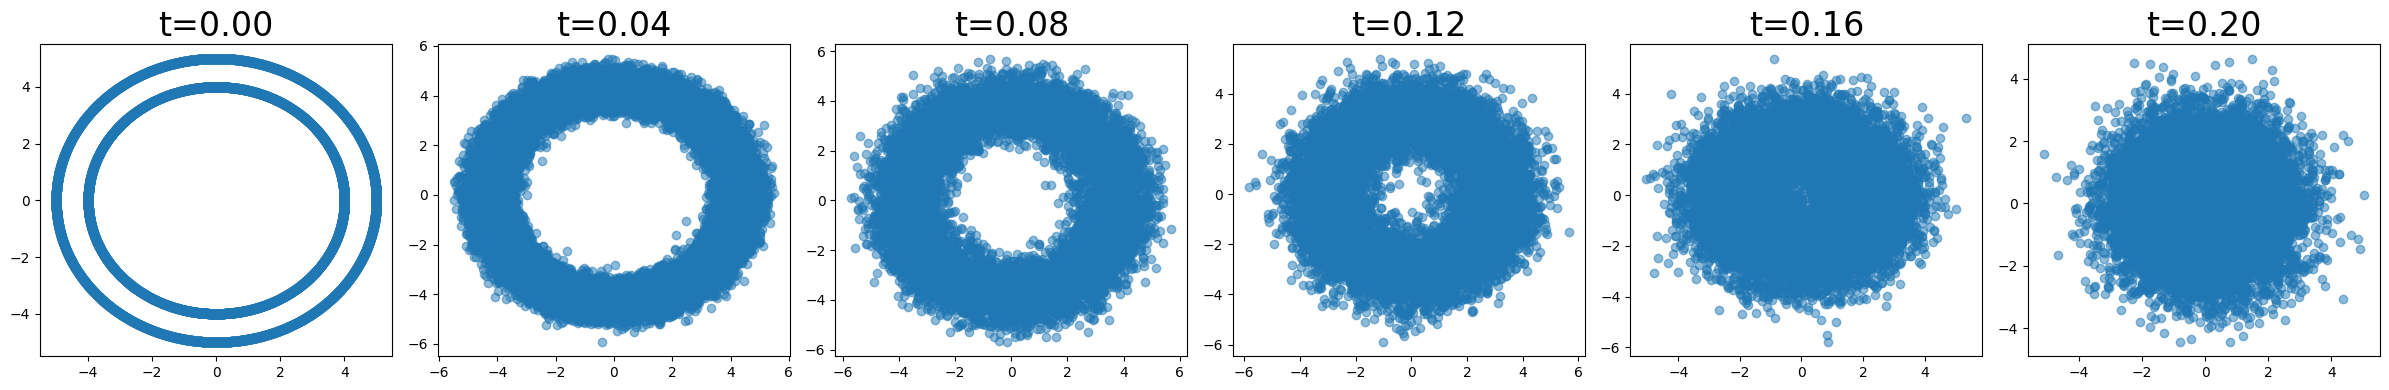

Image has been saved to circles_forward.png
begin to train
Step [1000/20000], lr=1.00e-02: loss = 1.93e+00
Step [2000/20000], lr=1.00e-02: loss = 1.83e+00
Step [3000/20000], lr=1.00e-02: loss = 1.77e+00
Step [4000/20000], lr=1.00e-02: loss = 1.73e+00
Step [5000/20000], lr=1.00e-02: loss = 1.70e+00
Step [6000/20000], lr=1.00e-02: loss = 1.75e+00
Step [7000/20000], lr=1.00e-02: loss = 1.74e+00
Step [8000/20000], lr=1.00e-02: loss = 1.74e+00
Step [9000/20000], lr=5.00e-03: loss = 1.69e+00
Step [10000/20000], lr=5.00e-03: loss = 1.65e+00
Step [11000/20000], lr=5.00e-03: loss = 1.74e+00
Step [12000/20000], lr=5.00e-03: loss = 1.71e+00
Step [13000/20000], lr=5.00e-03: loss = 1.67e+00
Step [14000/20000], lr=5.00e-03: loss = 1.71e+00
Step [15000/20000], lr=5.00e-03: loss = 1.70e+00
Step [16000/20000], lr=5.00e-03: loss = 1.69e+00
Step [17000/20000], lr=2.50e-03: loss = 1.68e+00
Step [18000/20000], lr=2.50e-03: loss = 1.69e+00
Step [19000/20000], lr=2.50e-03: loss = 1.66e+00
Step [20000/20000],

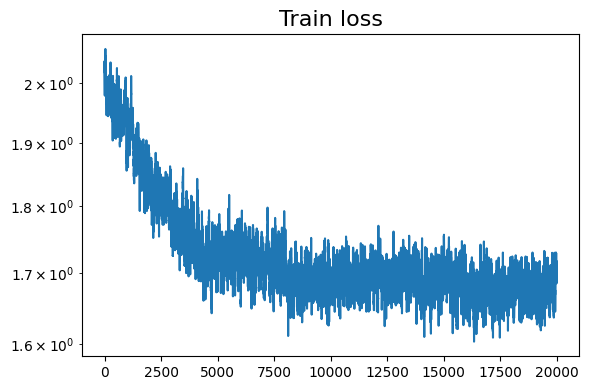

finish training
model saved to ckpts/sde_circles_2D_T-0.20_trainsteps-20000_bs-400_hdim-50\sde.pth
sampling with alpha=0.00 done, cost 174.93s
sampling with alpha=2.00 done, cost 164.72s
sampling with alpha=4.00 done, cost 174.66s


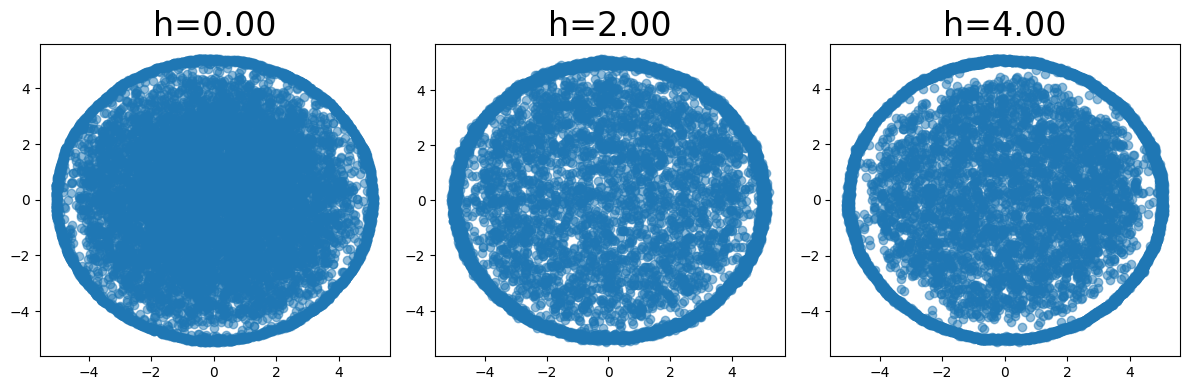

Image has been saved to circles_reverse.png


In [18]:
## hyper-parameters
T = 0.2                     # the terminal time
sample_size = 10000         # the number of random samples
hdim = 50                   # the width of neural network
steps = 20000               # training steps
batch_size = 400            # size of mini-batch for training
N = 5                       # control the number of visualizations

## define data
a = 5.0                     # control the scale of swissroll

x0, x1 = -1.2 * a, 1.2 * a      # the range of x coordinate to visualize and compute divergences
y0, y1 = -1.2 * a, 1.2 * a      # the range of y coordinate to visualize and compute divergences

## define sde model
beta0 = 0.1                     # beta at t = 0
beta1 = 20.0                    # beta at t = T

data = []

# data_dict = {"SwissRoll": SwissRoll(noise=0.0, a=a), "scurve": SCurve(noise=0.0, a=a), "moons": Moons(noise=0.0, a=a), "circles": Circles(Moons(noise=0.0, a=a))}
data_dict = {"circles": Circles(noise=0.0, a=a)}
for item in data_dict.items():
    data_name, true_data = item
    data_dim = true_data.data_dim

    model = SDE(T=T, beta0=beta0, beta1=beta1, sde_type="vp", beta_type="linear", data_dim=data_dim, hidden_dim=hdim)
    model.apply(weight_init)
    
    ## create directories for saving results
    model_dir = f"sde_{data_name}_2D_T-{T:.2f}_trainsteps-{steps:d}_bs-{batch_size:d}_hdim-{hdim:d}"
    output_dir = f"outputs/{model_dir}"
    ckpt_dir = f"ckpts/{model_dir}"
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir, exist_ok=True)
    visualize_forward_process(true_data, model, sample_size, T, N, data_dim, savename=f"{data_name}_forward.png")
    train(model, ckpt_dir, true_data, batch_size, steps)
    visualize_reverse_process(model, sample_size, data_dim, savename=f"{data_name}_reverse.png")

sampling with alpha=12.00 done, cost 173.00s


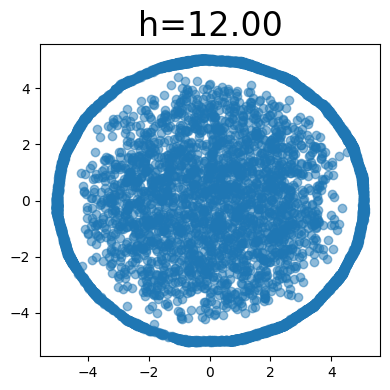

Image has been saved to circles_reverse_10.png


In [24]:
visualize_reverse_process(model, sample_size, data_dim, savename=f"{data_name}_reverse_10.png")

## Evaluate

h=4.00: js=0.3897, kl=0.0077, wd=0.0013
h=3.56: js=0.3954, kl=0.0104, wd=0.0014
h=3.11: js=0.4091, kl=0.0081, wd=0.0017
h=2.67: js=0.4181, kl=0.0093, wd=0.0020
h=2.22: js=0.4248, kl=0.0062, wd=0.0024
h=1.78: js=0.4311, kl=0.0062, wd=0.0030
h=1.33: js=0.4363, kl=0.0062, wd=0.0037
h=0.89: js=0.4446, kl=0.0053, wd=0.0041
h=0.44: js=0.4748, kl=0.0116, wd=0.0043
h=0.00: js=0.5425, kl=0.0342, wd=0.0045


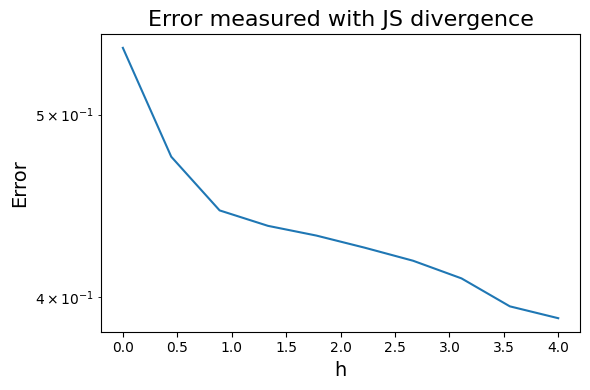

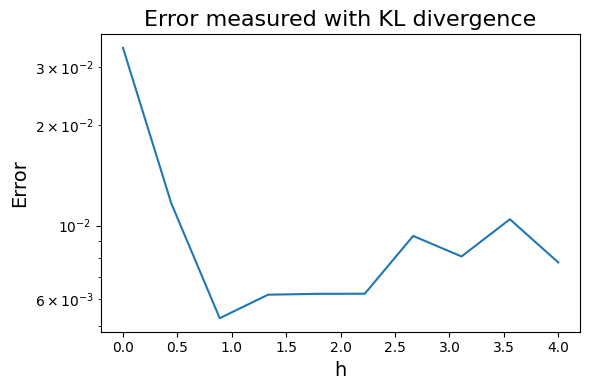

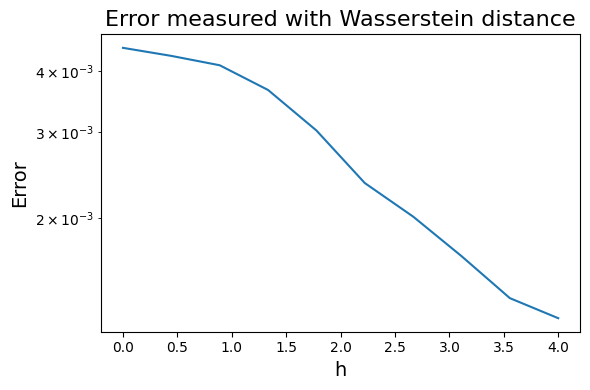

In [54]:
data = list()

for h in np.linspace(start=0.0, stop=h_alphas[-1], num=10, endpoint=True)[::-1]:
# for sa in [sf_alpha]:

    x_0 = true_data.sample(sample_size)
    x_0 = torch.from_numpy(x_0).view(-1, data_dim)

    x_0_gen = model.sample(x_t=x_T, T=0, N=reverse_N, to_numpy=True, sf_alpha=h)

    js, kl, wd = evaluate_2d(true_data=x_0.detach().numpy(), fake_data=x_0_gen, x0=x0, x1=x1, y0=y0, y1=y1)

    print(f"h={h:.2f}: js={js:.4f}, kl={kl:.4f}, wd={wd:.4f}")

    data.append([h, js, kl, wd])

data = np.array(data)

visualize_line(data=data[:, 1], yscale="log", xaxis=data[:, 0], xl=r"$\mathsf{h}$", yl="Error", title="Error measured with JS divergence", savename=None)
visualize_line(data=data[:, 2], yscale="log", xaxis=data[:, 0], xl=r"$\mathsf{h}$", yl="Error", title="Error measured with KL divergence", savename=None)
visualize_line(data=data[:, 3], yscale="log", xaxis=data[:, 0], xl=r"$\mathsf{h}$", yl="Error", title="Error measured with Wasserstein distance", savename=None)

